In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
import cv2
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
warnings.filterwarnings("ignore")

In [2]:
img_folder = '/kaggle/input/spr-x-ray-gender/kaggle/kaggle/train/'
label_file = '/kaggle/input/spr-x-ray-gender/train_gender.csv'

labels_df = pd.read_csv(label_file)
labels_df.head()

,imageId,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [3]:
# associating the image name with the class
labels_df['imageId'] = labels_df['imageId'].astype(str) + '.png'
labels_df['gender'] = labels_df['gender'].astype(str)

for i in range(len(labels_df)):
    labels_df['imageId'][i] = labels_df['imageId'][i].zfill(10)
labels_df.head()

,imageId,gender
0,000000.png,0
1,000001.png,0
2,000002.png,1
3,000003.png,1
4,000004.png,0


In [4]:
image_generator = ImageDataGenerator(rescale=1./255)

train_generator = image_generator.flow_from_dataframe(
    dataframe=labels_df,
    directory=img_folder,
    x_col='imageId',
    y_col='gender', 
    target_size=(256, 256),
    batch_size=40,
    class_mode='categorical'
)

Found 10702 validated image filenames belonging to 2 classes.


In [5]:
train_images, train_labels = next(train_generator)
labels_names={0: 'Mulher', 1: 'Homem'}

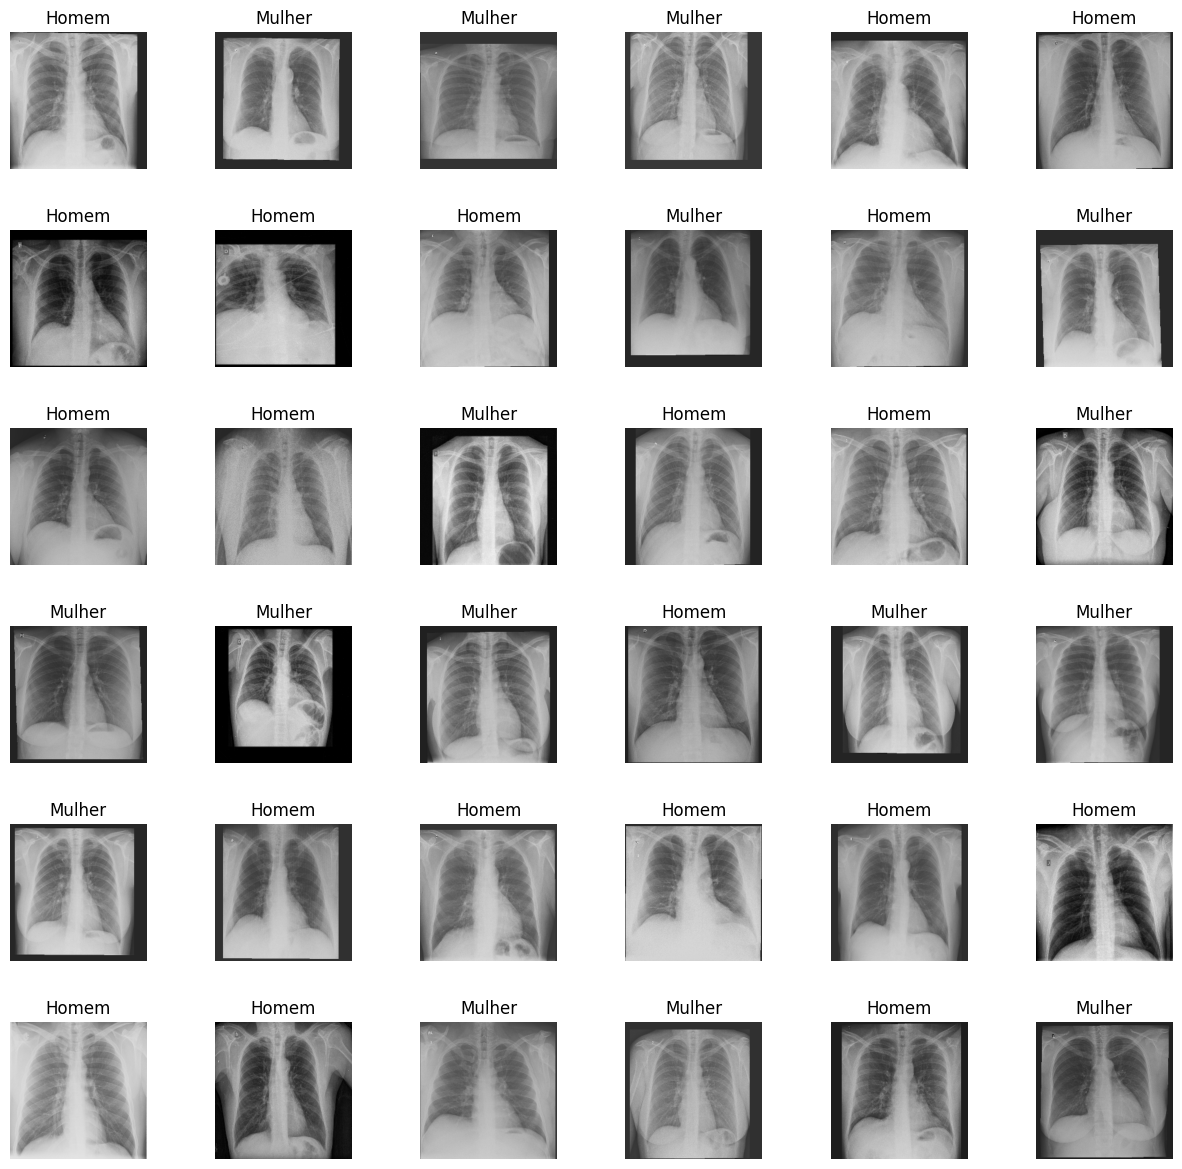

In [6]:
fig, axis = plt.subplots(6, 6, figsize=(15, 15))
axis = axis.ravel()
for i in np.arange(0, 36):
    axis[i].imshow(train_images[i])
    axis[i].set_title(labels_names[np.argmax(train_labels[i])])
    axis[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [7]:
base_model = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(256,256,3)),
    input_shape=None,
    pooling=None,
    classes=2,
)

234545216/234545216 [==============================] - 1s 0us/step


In [8]:
# freezing the network weights, with the exception of the last 5 layers
for layer in base_model.layers[:-5]:
    layers.trainable = False

In [9]:
# defining the structure of the network
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(4096, activation ='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4096, activation ='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'sigmoid')(head_model)

In [10]:
# compiling and training the model
model = Model(inputs=base_model.input, outputs=head_model)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='weights.hdf5')
history = model.fit_generator(train_generator, epochs = 4,  callbacks=[checkpointer])

Epoch 1/4
268/268 [==============================] - 752s 3s/step - loss: 0.4127 - accuracy: 0.9222
Epoch 2/4
268/268 [==============================] - 609s 2s/step - loss: 0.0945 - accuracy: 0.9736
Epoch 3/4
268/268 [==============================] - 599s 2s/step - loss: 0.0499 - accuracy: 0.9850
Epoch 4/4
268/268 [==============================] - 594s 2s/step - loss: 0.0265 - accuracy: 0.9919


In [12]:
prediction = []
imagem_name = []
image = []
test_directory = '/kaggle/input/spr-x-ray-gender/kaggle/kaggle/test/'

for filename in glob.glob(os.path.join(test_directory, '*.png')):
    img = cv2.imread(filename)
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    
    # making the predictions
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    imagem_name.append(os.path.basename(filename))
    
results = pd.DataFrame({'id': imagem_name, 'prediction': prediction})

1/1 [==============================] - 0s 46ms/step


In [13]:
results = results.sort_values(by='id').reset_index(drop=True)
results.head()

,id,prediction
0,000000.png,1
1,000001.png,0
2,000002.png,1
3,000003.png,0
4,000004.png,1


In [14]:
for i in range(len(results)):
    results['id'][i] = int(results['id'][i].replace('.png', ''))

results.rename(columns={'id': 'imageId', 'prediction': 'gender'}, inplace=True)
results.head()

,imageId,gender
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [15]:
results.to_csv('final.csv', index=False)